In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

## Part 1: ICU Monitoring Data - Resampling

In medical settings, you often have high-frequency data (hourly monitoring) that needs to be summarized for analysis or reporting. Resampling allows you to convert between frequencies while aggregating the data appropriately.

### Understanding Resampling

Resampling is similar to groupby operations (from Lecture 5), but instead of grouping by categories, you're grouping by time intervals. Downsampling aggregates higher frequency data to lower frequency (e.g., hourly to daily), while upsampling converts lower frequency to higher frequency (often creating missing values).

### Load and Prepare ICU Data

Let's create realistic ICU monitoring data to work with. This simulates hourly measurements of vital signs over 6 months, which is typical for ICU patient monitoring.

In [2]:
# Simulate hourly ICU patient monitoring data (6 months)
print("=== ICU Patient Monitoring Data ===\n")

# Create hourly dates for 6 months
hourly_dates = pd.date_range('2023-01-01', periods=24*30*6, freq='h')

# Generate realistic ICU monitoring data
np.random.seed(42)
icu_data = pd.DataFrame({
    'heart_rate': np.random.randint(60, 100, len(hourly_dates)),
    'blood_pressure_systolic': np.random.randint(110, 140, len(hourly_dates)),
    'blood_pressure_diastolic': np.random.randint(70, 90, len(hourly_dates)),
    'oxygen_saturation': np.random.randint(95, 100, len(hourly_dates)),
    'temperature': np.random.normal(98.6, 0.5, len(hourly_dates))
}, index=hourly_dates)

print(f"ICU data shape: {icu_data.shape}")
print(f"Date range: {icu_data.index.min()} to {icu_data.index.max()}")
print(f"\nSample data:")
print(icu_data.head())
print(f"\nData summary:")
print(icu_data.describe())

=== ICU Patient Monitoring Data ===

ICU data shape: (4320, 5)
Date range: 2023-01-01 00:00:00 to 2023-06-29 23:00:00

Sample data:
                     heart_rate  blood_pressure_systolic  \
2023-01-01 00:00:00          98                      117   
2023-01-01 01:00:00          88                      131   
2023-01-01 02:00:00          74                      129   
2023-01-01 03:00:00          67                      139   
2023-01-01 04:00:00          80                      115   

                     blood_pressure_diastolic  oxygen_saturation  temperature  
2023-01-01 00:00:00                        73                 99    98.630594  
2023-01-01 01:00:00                        87                 97    98.561809  
2023-01-01 02:00:00                        87                 98    98.826498  
2023-01-01 03:00:00                        86                 99    98.847101  
2023-01-01 04:00:00                        81                 96    99.032558  

Data summary:
        hear

Notice we have over 4,000 hourly measurements. This volume of data is common in medical monitoring but can be overwhelming for analysis. Resampling helps us create manageable summaries while preserving important information.

### Basic Resampling - Hourly to Daily

Downsampling from hourly to daily data reduces complexity while preserving important patterns. We can aggregate using mean, max, min, or other functions depending on what's clinically relevant.

**Note:** When resampling DataFrames (not Series) that contain non-numeric columns like patient IDs, you'll need to either select only numeric columns first using `df.select_dtypes(include=[np.number])`, or specify which columns to aggregate in `.agg()`. In this demo, we're working with Series (single columns), so this isn't an issue, but keep it in mind for DataFrames.

In [3]:
# Resample hourly data to daily (aggregate to daily summaries)
print("=== Resampling: Hourly to Daily ===\n")

# Daily resampling with different aggregations
daily_icu = pd.DataFrame({
    'heart_rate_mean': icu_data['heart_rate'].resample('D').mean(),
    'heart_rate_max': icu_data['heart_rate'].resample('D').max(),
    'heart_rate_min': icu_data['heart_rate'].resample('D').min(),
    'blood_pressure_systolic_mean': icu_data['blood_pressure_systolic'].resample('D').mean(),
    'oxygen_saturation_mean': icu_data['oxygen_saturation'].resample('D').mean(),
    'temperature_mean': icu_data['temperature'].resample('D').mean(),
    'observation_count': icu_data['heart_rate'].resample('D').count()  # Count of hourly readings
})

print(f"Daily resampled shape: {daily_icu.shape}")
print(f"Original hourly shape: {icu_data.shape}")
print(f"Reduction: {icu_data.shape[0] / daily_icu.shape[0]:.1f}x fewer rows")
print(f"\nDaily summary:")
print(daily_icu.head())

=== Resampling: Hourly to Daily ===

Daily resampled shape: (180, 7)
Original hourly shape: (4320, 5)
Reduction: 24.0x fewer rows

Daily summary:
            heart_rate_mean  heart_rate_max  heart_rate_min  \
2023-01-01        80.916667              99              61   
2023-01-02        77.541667              98              61   
2023-01-03        78.833333              99              61   
2023-01-04        77.541667              98              60   
2023-01-05        81.541667              99              60   

            blood_pressure_systolic_mean  oxygen_saturation_mean  \
2023-01-01                    123.416667               97.625000   
2023-01-02                    127.750000               97.083333   
2023-01-03                    126.208333               97.458333   
2023-01-04                    124.791667               96.916667   
2023-01-05                    125.375000               97.041667   

            temperature_mean  observation_count  
2023-01-01      

Daily summaries are often more useful than hourly data for reporting. The mean provides the average, while max/min can identify critical events. The observation count helps identify days with missing data.

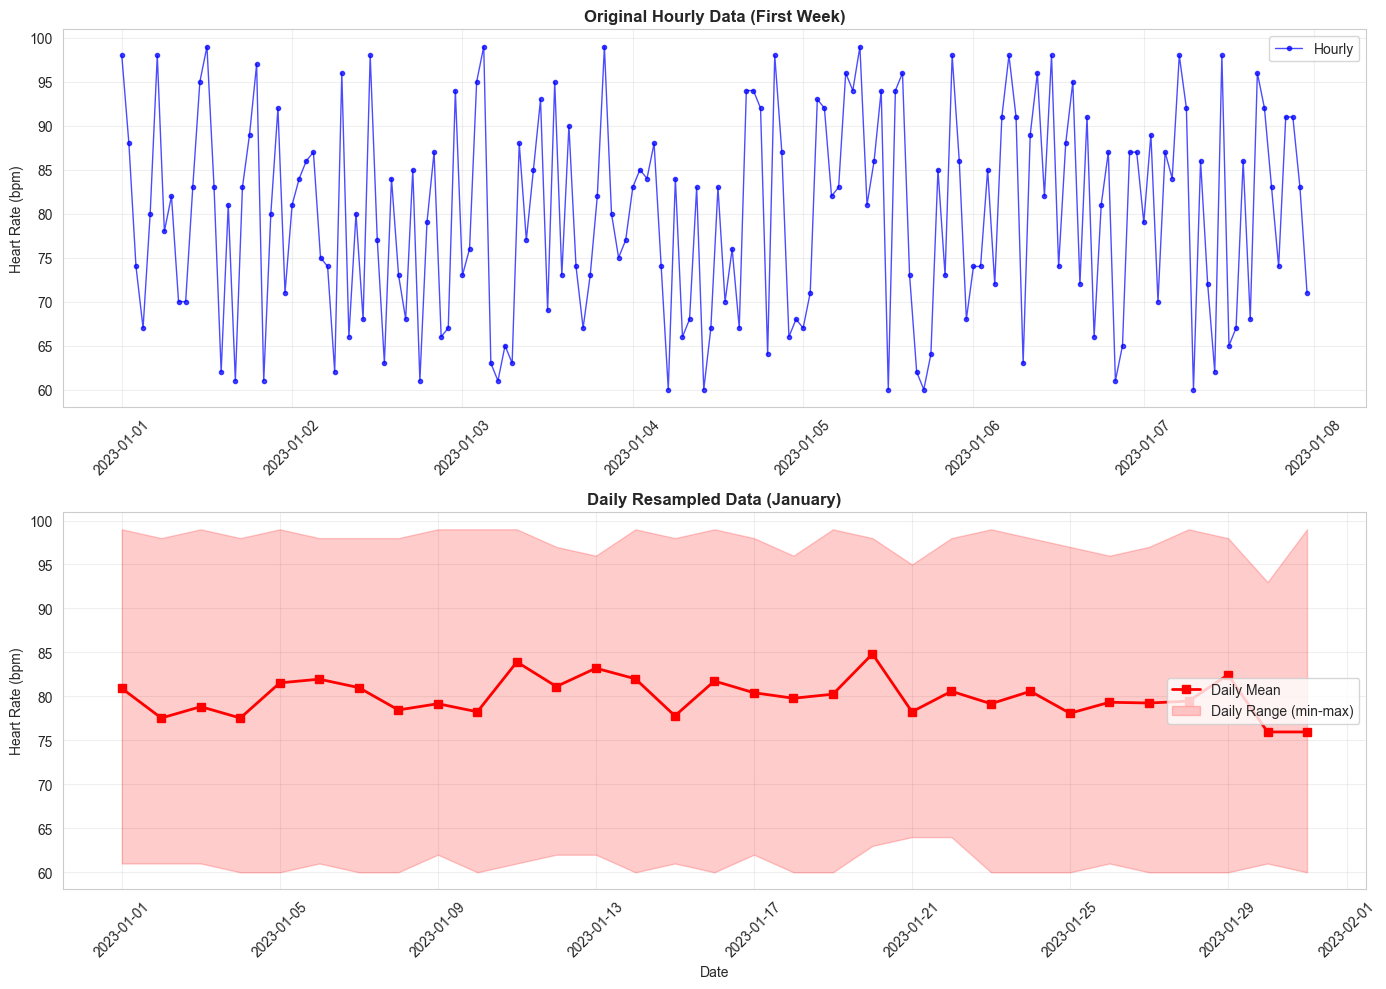

In [4]:
# Visualize resampling effect: hourly vs daily
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Sample of hourly data (first week)
hourly_sample = icu_data['heart_rate']['2023-01-01':'2023-01-07']
axes[0].plot(hourly_sample.index, hourly_sample.values, 
             marker='o', markersize=3, alpha=0.7, linewidth=1, color='blue', label='Hourly')
axes[0].set_title('Original Hourly Data (First Week)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Heart Rate (bpm)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Daily resampled (first month)
daily_sample = daily_icu.loc['2023-01-01':'2023-01-31']
axes[1].plot(daily_sample.index, daily_sample['heart_rate_mean'], 
             marker='s', markersize=6, linewidth=2, color='red', label='Daily Mean')
axes[1].fill_between(daily_sample.index,
                     daily_sample['heart_rate_min'],
                     daily_sample['heart_rate_max'],
                     alpha=0.2, color='red', label='Daily Range (min-max)')
axes[1].set_title('Daily Resampled Data (January)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Heart Rate (bpm)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Resampling with Multiple Aggregations

Just like groupby operations, you can apply multiple aggregation functions when resampling. This allows you to calculate comprehensive statistics for each time period.

In [5]:
# Resample with multiple aggregations (like groupby from Lecture 5)
print("=== Resampling with Multiple Aggregations ===\n")

# Resample to weekly with multiple statistics
weekly_stats = icu_data.resample('W').agg({
    'heart_rate': ['mean', 'std', 'min', 'max'],
    'blood_pressure_systolic': ['mean', 'std'],
    'oxygen_saturation': ['mean', 'min'],
    'temperature': ['mean', 'std']
})

print(f"Weekly stats shape: {weekly_stats.shape}")
print(f"\nWeekly statistics:")
print(weekly_stats.head())

# Resample to monthly
monthly_stats = icu_data.resample('ME').agg({
    'heart_rate': 'mean',
    'blood_pressure_systolic': 'mean',
    'oxygen_saturation': 'mean',
    'temperature': 'mean'
})

print(f"\nMonthly averages:")
print(monthly_stats.head())

=== Resampling with Multiple Aggregations ===

Weekly stats shape: (27, 10)

Weekly statistics:
           heart_rate                    blood_pressure_systolic            \
                 mean        std min max                    mean       std   
2023-01-01  80.916667  12.086344  61  99              123.416667  9.568593   
2023-01-08  79.553571  12.073507  60  99              125.422619  7.964365   
2023-01-15  80.779762  11.578643  60  99              125.404762  8.492503   
2023-01-22  80.839286  11.158805  60  99              124.767857  8.545036   
2023-01-29  79.761905  11.943599  60  99              125.494048  8.309865   

           oxygen_saturation     temperature            
                        mean min        mean       std  
2023-01-01         97.625000  95   98.687351  0.499583  
2023-01-08         97.017857  95   98.595609  0.489494  
2023-01-15         97.160714  95   98.575729  0.500445  
2023-01-22         97.023810  95   98.559092  0.490521  
2023-01-29     

The ability to calculate multiple statistics simultaneously (mean, std, min, max) in one resampling operation is incredibly efficient. This creates a comprehensive view of patient vital signs at different time scales.

### Handling Missing Data in Resampling

When upsampling (converting to higher frequency), you often create missing values because there's no data for the new time points. Understanding how to handle these missing values is crucial for time series analysis.

In [6]:
# Demonstrate handling missing data (upsampling)
print("=== Handling Missing Data in Resampling ===\n")

# Create daily summary (some days missing)
daily_summary = icu_data['heart_rate'].resample('D').mean()

# Upsample to hourly (creates missing values)
hourly_upsampled = daily_summary.resample('h').asfreq()
print(f"Upsampled data - missing values: {hourly_upsampled.isna().sum()}")
print(f"Missing percentage: {hourly_upsampled.isna().sum() / len(hourly_upsampled) * 100:.1f}%")

# Forward fill missing values
hourly_filled = daily_summary.resample('h').ffill()
print(f"\nAfter forward fill - missing values: {hourly_filled.isna().sum()}")

# Interpolate missing values
hourly_interpolated = daily_summary.resample('h').interpolate()
print(f"After interpolation - missing values: {hourly_interpolated.isna().sum()}")

=== Handling Missing Data in Resampling ===

Upsampled data - missing values: 4117
Missing percentage: 95.8%

After forward fill - missing values: 0
After interpolation - missing values: 0


When upsampling, you must choose how to handle missing values. Forward fill (`ffill`) carries the last value forward, while interpolation estimates intermediate values. The choice depends on your analysis needs - forward fill is simpler but less accurate, while interpolation is more sophisticated but may introduce artifacts.

## Part 2: Rolling Window Operations

Rolling windows are like looking through a moving frame - they smooth out noise while preserving trends. This is essential for identifying patterns in noisy medical data where individual measurements might fluctuate significantly.

### Understanding Rolling Windows

A rolling window calculates statistics over a fixed-size window that moves through the time series. For example, a 7-day rolling mean calculates the average of the last 7 days at each point. This smooths out daily fluctuations while preserving weekly trends.

### Basic Rolling Window Statistics

Let's apply rolling windows to our ICU data to identify trends in patient vital signs. Rolling windows are particularly useful for smoothing noisy data and identifying underlying patterns.

In [7]:
# Apply rolling windows to ICU data
print("=== Rolling Window Operations ===\n")

# Calculate rolling statistics for heart rate
daily_heart_rate = pd.DataFrame({
    'heart_rate': icu_data['heart_rate'].resample('D').mean()
})

# 7-day rolling window (1 week)
daily_heart_rate['rolling_7d_mean'] = daily_heart_rate['heart_rate'].rolling(window=7).mean()
daily_heart_rate['rolling_7d_std'] = daily_heart_rate['heart_rate'].rolling(window=7).std()
daily_heart_rate['rolling_7d_min'] = daily_heart_rate['heart_rate'].rolling(window=7).min()
daily_heart_rate['rolling_7d_max'] = daily_heart_rate['heart_rate'].rolling(window=7).max()

# 30-day rolling window (1 month)
daily_heart_rate['rolling_30d_mean'] = daily_heart_rate['heart_rate'].rolling(window=30).mean()

print("Daily heart rate with rolling statistics:")
print(daily_heart_rate.head(10))
print(f"\nRolling statistics summary:")
print(daily_heart_rate[['rolling_7d_mean', 'rolling_30d_mean']].describe())

=== Rolling Window Operations ===

Daily heart rate with rolling statistics:
            heart_rate  rolling_7d_mean  rolling_7d_std  rolling_7d_min  \
2023-01-01   80.916667              NaN             NaN             NaN   
2023-01-02   77.541667              NaN             NaN             NaN   
2023-01-03   78.833333              NaN             NaN             NaN   
2023-01-04   77.541667              NaN             NaN             NaN   
2023-01-05   81.541667              NaN             NaN             NaN   
2023-01-06   81.958333              NaN             NaN             NaN   
2023-01-07   81.000000        79.904762        1.890172       77.541667   
2023-01-08   78.458333        79.553571        1.899183       77.541667   
2023-01-09   79.166667        79.785714        1.701278       77.541667   
2023-01-10   78.250000        79.702381        1.768655       77.541667   

            rolling_7d_max  rolling_30d_mean  
2023-01-01             NaN               NaN  
202

Rolling windows help identify trends in patient vital signs. A 7-day rolling mean smooths out daily fluctuations while preserving weekly patterns, while a 30-day rolling mean identifies longer-term trends. The rolling standard deviation helps identify periods of increased variability.

### Advanced Rolling Operations

Rolling windows can be customized in various ways - centered windows look both forward and backward, expanding windows use all data from the start, and minimum periods allow calculations even when the window isn't full.

In [8]:
# Advanced rolling operations
print("=== Advanced Rolling Operations ===\n")

# Centered rolling window (looks both forward and backward)
daily_heart_rate['rolling_7d_centered'] = daily_heart_rate['heart_rate'].rolling(
    window=7, center=True
).mean()

# Expanding window (from start to current)
daily_heart_rate['expanding_mean'] = daily_heart_rate['heart_rate'].expanding().mean()

# Rolling with minimum periods (starts calculating earlier)
daily_heart_rate['rolling_7d_min_periods'] = daily_heart_rate['heart_rate'].rolling(
    window=7, min_periods=3
).mean()

print("Advanced rolling operations:")
print(daily_heart_rate[['heart_rate', 'rolling_7d_centered', 'expanding_mean']].head(10))

=== Advanced Rolling Operations ===

Advanced rolling operations:
            heart_rate  rolling_7d_centered  expanding_mean
2023-01-01   80.916667                  NaN       80.916667
2023-01-02   77.541667                  NaN       79.229167
2023-01-03   78.833333                  NaN       79.097222
2023-01-04   77.541667            79.904762       78.708333
2023-01-05   81.541667            79.553571       79.275000
2023-01-06   81.958333            79.785714       79.722222
2023-01-07   81.000000            79.702381       79.904762
2023-01-08   78.458333            80.613095       79.723958
2023-01-09   79.166667            80.553571       79.662037
2023-01-10   78.250000            80.732143       79.520833


Centered windows (`center=True`) look both forward and backward, which is useful for smoothing but introduces a delay. Expanding windows use all data from the start, creating a cumulative average that's useful for tracking overall trends. Minimum periods (`min_periods=3`) allow calculations even when the window isn't full, providing earlier results at the cost of less stability.

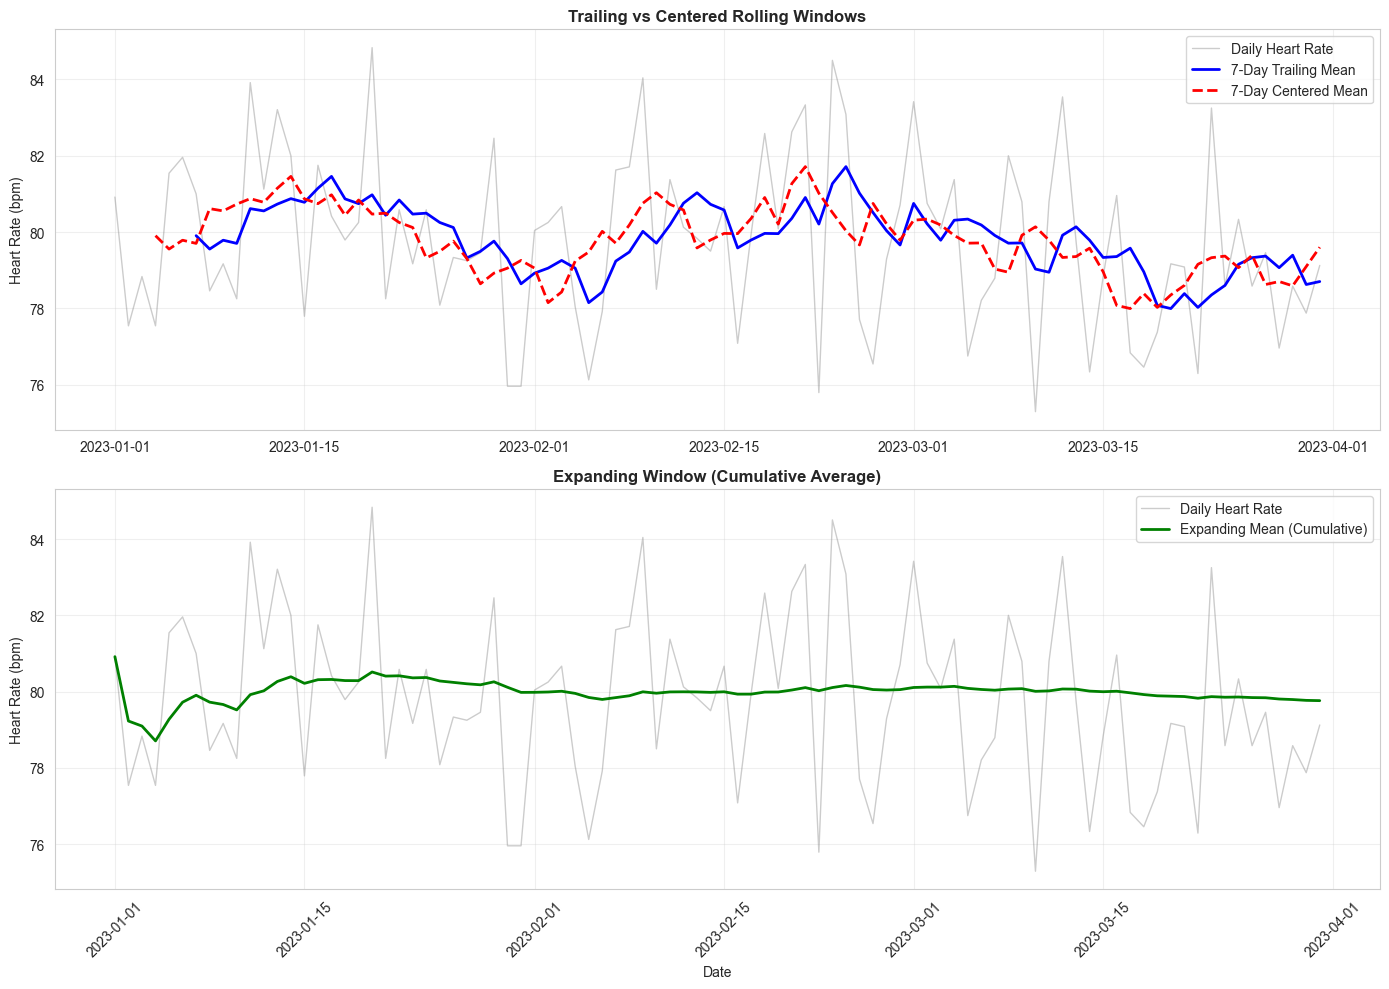

In [9]:
# Visualize advanced rolling operations
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Sample data for visualization
sample_period = daily_heart_rate['2023-01-01':'2023-03-31']

# Centered vs trailing window
axes[0].plot(sample_period.index, sample_period['heart_rate'], 
             alpha=0.4, linewidth=1, label='Daily Heart Rate', color='gray')
axes[0].plot(sample_period.index, sample_period['rolling_7d_mean'], 
             linewidth=2, label='7-Day Trailing Mean', color='blue')
axes[0].plot(sample_period.index, sample_period['rolling_7d_centered'], 
             linewidth=2, label='7-Day Centered Mean', color='red', linestyle='--')
axes[0].set_title('Trailing vs Centered Rolling Windows', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Heart Rate (bpm)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Expanding window
axes[1].plot(sample_period.index, sample_period['heart_rate'], 
             alpha=0.4, linewidth=1, label='Daily Heart Rate', color='gray')
axes[1].plot(sample_period.index, sample_period['expanding_mean'], 
             linewidth=2, label='Expanding Mean (Cumulative)', color='green')
axes[1].set_title('Expanding Window (Cumulative Average)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Heart Rate (bpm)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Exponentially Weighted Moving Average

Exponentially weighted moving averages (EWM) give more weight to recent observations, making them more responsive to recent changes. This is particularly useful in medical monitoring where recent trends are often more important than historical averages.

In [10]:
# Exponentially weighted moving average (more responsive to recent changes)
print("=== Exponentially Weighted Moving Average ===\n")

# Calculate EWM with different spans
daily_heart_rate['ewm_span_7'] = daily_heart_rate['heart_rate'].ewm(span=7).mean()
daily_heart_rate['ewm_span_30'] = daily_heart_rate['heart_rate'].ewm(span=30).mean()

# Compare with simple moving average
print("Comparison: Simple MA vs EWM")
print(daily_heart_rate[['heart_rate', 'rolling_7d_mean', 'ewm_span_7']].head(10))

# EWM with different parameters
daily_heart_rate['ewm_alpha_0.3'] = daily_heart_rate['heart_rate'].ewm(alpha=0.3).mean()
daily_heart_rate['ewm_halflife_7'] = daily_heart_rate['heart_rate'].ewm(halflife=7).mean()

print(f"\nEWM comparison:")
print(daily_heart_rate[['ewm_span_7', 'ewm_alpha_0.3', 'ewm_halflife_7']].head(10))

=== Exponentially Weighted Moving Average ===

Comparison: Simple MA vs EWM
            heart_rate  rolling_7d_mean  ewm_span_7
2023-01-01   80.916667              NaN   80.916667
2023-01-02   77.541667              NaN   78.988095
2023-01-03   78.833333              NaN   78.921171
2023-01-04   77.541667              NaN   78.416667
2023-01-05   81.541667              NaN   79.440994
2023-01-06   81.958333              NaN   80.206588
2023-01-07   81.000000        79.904762   80.435497
2023-01-08   78.458333        79.553571   79.886216
2023-01-09   79.166667        79.785714   79.691725
2023-01-10   78.250000        79.702381   79.309786

EWM comparison:
            ewm_span_7  ewm_alpha_0.3  ewm_halflife_7
2023-01-01   80.916667      80.916667       80.916667
2023-01-02   78.988095      78.931373       79.145686
2023-01-03   78.921171      78.886606       79.031106
2023-01-04   78.416667      78.355639       78.601756
2023-01-05   79.440994      79.504544       79.311535
2023-01-06 

In clinical settings, recent trends are often more important than historical averages. EWM responds faster to recent changes while still incorporating historical data. The `span` parameter controls how much weight to give recent observations - smaller spans are more responsive, larger spans are more stable.

**Parameter choices**:
- **span**: Roughly equivalent to a simple moving average window size
- **alpha**: Direct smoothing factor (0 < alpha <= 1), where larger alpha = more weight to recent
- **halflife**: Half-life of exponential decay, where values decay to half their weight after the halflife period

## Part 3: Visualization with Resampling and Rolling Windows

Visualizing resampling and rolling window operations helps you understand their effects and choose appropriate parameters for your analysis.

### Visualizing Resampling Effects

Comparing data at different frequencies helps you understand what information is preserved or lost at different scales.

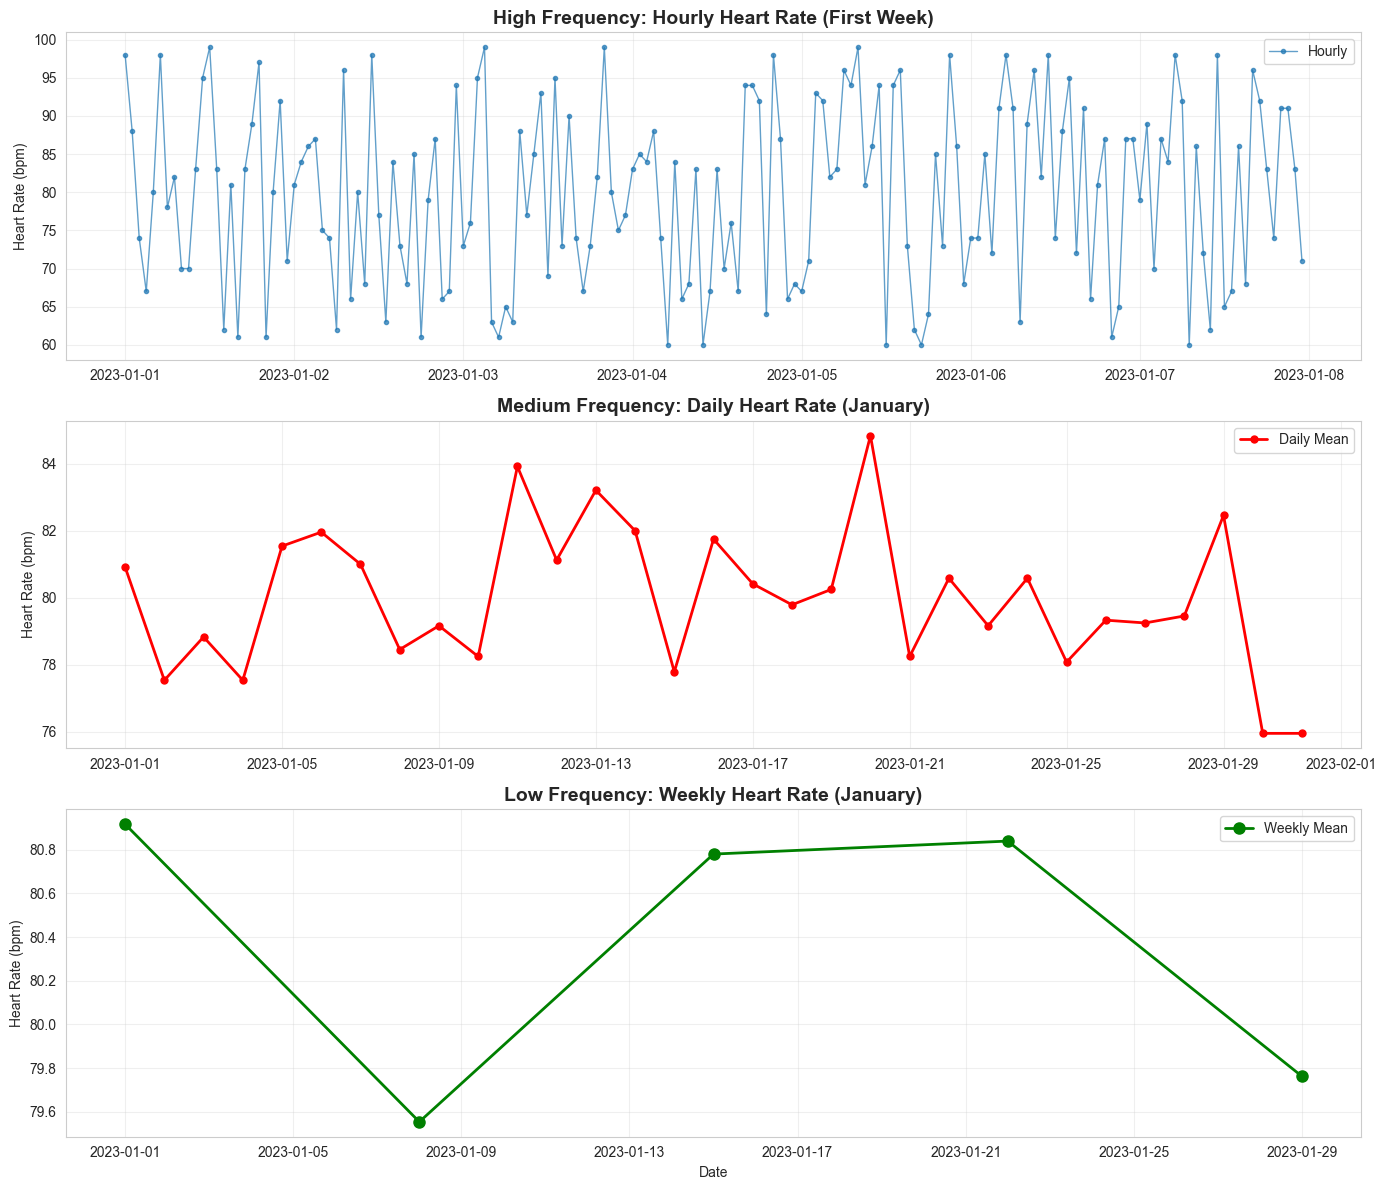

In [11]:
# Visualize resampling effects
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Original hourly data (sample of first week)
hourly_sample = icu_data['heart_rate']['2023-01-01':'2023-01-07']
axes[0].plot(hourly_sample.index, hourly_sample.values, 
             marker='o', markersize=3, alpha=0.7, linewidth=1, label='Hourly')
axes[0].set_title('High Frequency: Hourly Heart Rate (First Week)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Heart Rate (bpm)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Daily resampled
daily_sample = daily_heart_rate['2023-01-01':'2023-01-31']
axes[1].plot(daily_sample.index, daily_sample['heart_rate'], 
             marker='o', markersize=5, linewidth=2, label='Daily Mean', color='red')
axes[1].set_title('Medium Frequency: Daily Heart Rate (January)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Heart Rate (bpm)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Weekly resampled
weekly_sample = daily_heart_rate['heart_rate'].resample('W').mean()['2023-01-01':'2023-01-31']
axes[2].plot(weekly_sample.index, weekly_sample.values, 
             marker='o', markersize=8, linewidth=2, label='Weekly Mean', color='green')
axes[2].set_title('Low Frequency: Weekly Heart Rate (January)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Heart Rate (bpm)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Notice how higher frequency data (hourly) shows more variability and noise, while lower frequency data (weekly) shows smoother trends. The choice of frequency depends on your analysis goals - use higher frequency for detailed analysis, lower frequency for trend identification.

### Visualizing Rolling Windows

Comparing rolling windows with different sizes helps you understand how window size affects smoothing and trend detection.

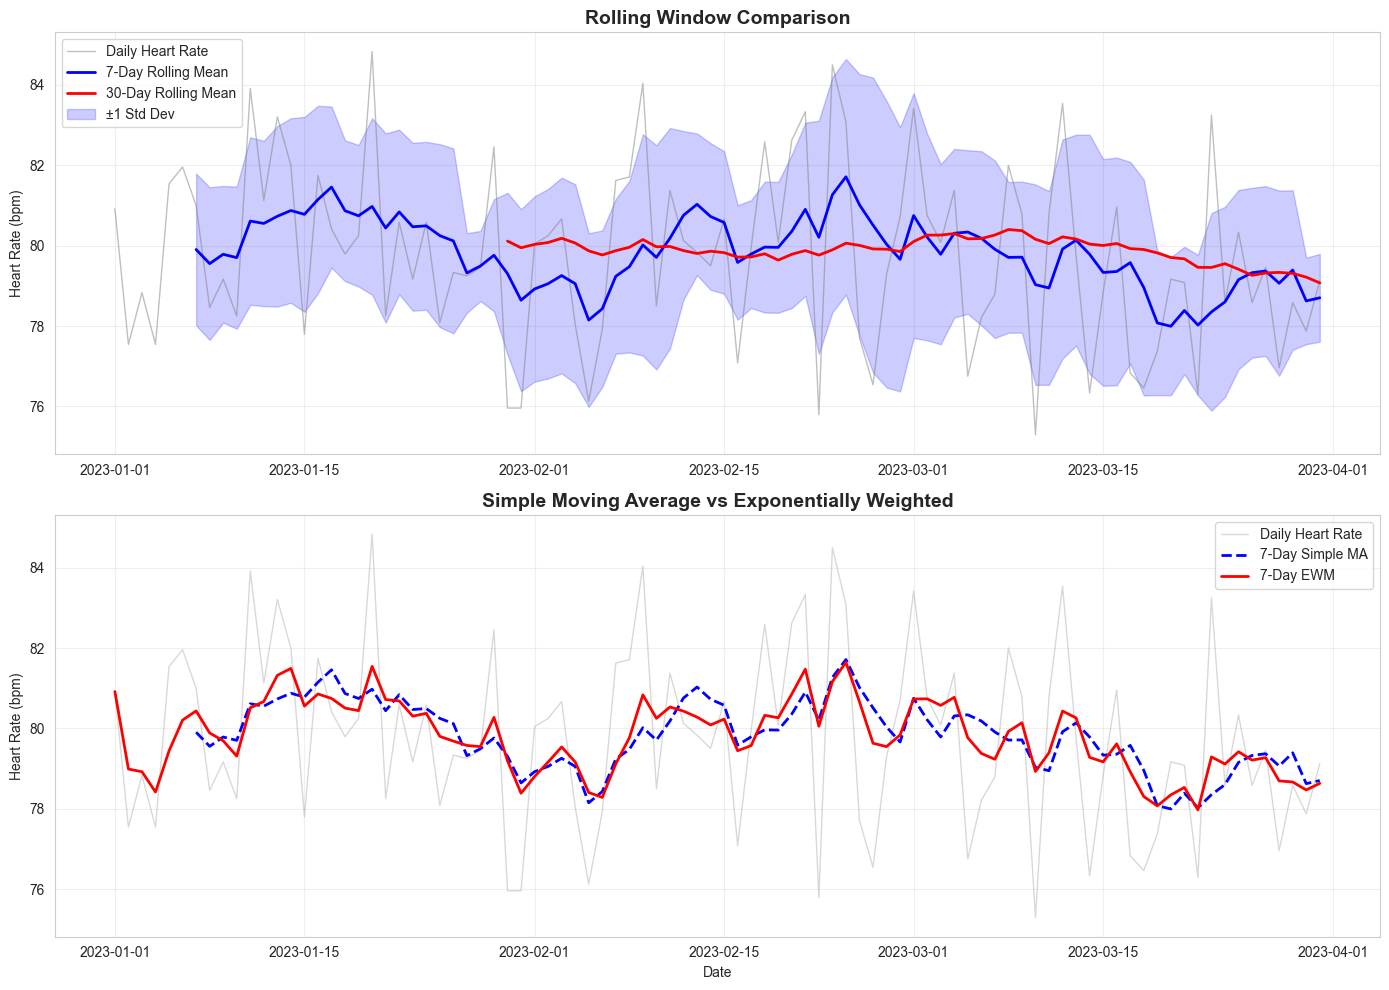

In [12]:
# Visualize rolling window effects
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Rolling mean comparison
sample_data = daily_heart_rate['2023-01-01':'2023-03-31']
axes[0].plot(sample_data.index, sample_data['heart_rate'], 
             alpha=0.5, linewidth=1, label='Daily Heart Rate', color='gray')
axes[0].plot(sample_data.index, sample_data['rolling_7d_mean'], 
             linewidth=2, label='7-Day Rolling Mean', color='blue')
axes[0].plot(sample_data.index, sample_data['rolling_30d_mean'], 
             linewidth=2, label='30-Day Rolling Mean', color='red')
axes[0].fill_between(sample_data.index,
                     sample_data['rolling_7d_mean'] - sample_data['rolling_7d_std'],
                     sample_data['rolling_7d_mean'] + sample_data['rolling_7d_std'],
                     alpha=0.2, color='blue', label='±1 Std Dev')
axes[0].set_title('Rolling Window Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Heart Rate (bpm)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# EWM vs Simple MA
axes[1].plot(sample_data.index, sample_data['heart_rate'], 
             alpha=0.3, linewidth=1, label='Daily Heart Rate', color='gray')
axes[1].plot(sample_data.index, sample_data['rolling_7d_mean'], 
             linewidth=2, label='7-Day Simple MA', color='blue', linestyle='--')
axes[1].plot(sample_data.index, sample_data['ewm_span_7'], 
             linewidth=2, label='7-Day EWM', color='red')
axes[1].set_title('Simple Moving Average vs Exponentially Weighted', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Heart Rate (bpm)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Notice how the 7-day rolling mean is smoother than daily data but still responsive, while the 30-day rolling mean shows longer-term trends. The EWM follows recent changes more closely than the simple moving average, making it more responsive to recent trends.

## Part 4: Combining Concepts - Multi-Variable Analysis

Real-world analysis often involves multiple variables. Let's combine resampling and rolling windows to analyze multiple vital signs simultaneously.

### Multi-Variable Rolling Analysis

Analyzing multiple variables together helps identify relationships and patterns that might not be apparent when analyzing variables individually.

In [13]:
# Analyze multiple variables with rolling windows
print("=== Multi-Variable Rolling Analysis ===\n")

# Create daily summary for all variables
daily_summary = icu_data.resample('D').agg({
    'heart_rate': 'mean',
    'blood_pressure_systolic': 'mean',
    'oxygen_saturation': 'mean',
    'temperature': 'mean'
})

# Calculate rolling correlations (7-day window)
rolling_corr = daily_summary['heart_rate'].rolling(window=7).corr(
    daily_summary['blood_pressure_systolic']
)

print("Rolling correlation (7-day window) between heart rate and blood pressure:")
print(rolling_corr.head(10))

# Multiple rolling statistics
daily_summary['hr_rolling_mean'] = daily_summary['heart_rate'].rolling(window=7).mean()
daily_summary['bp_rolling_mean'] = daily_summary['blood_pressure_systolic'].rolling(window=7).mean()
daily_summary['temp_rolling_mean'] = daily_summary['temperature'].rolling(window=7).mean()

print(f"\nDaily summary with rolling statistics:")
print(daily_summary.head(10))

=== Multi-Variable Rolling Analysis ===

Rolling correlation (7-day window) between heart rate and blood pressure:
2023-01-01         NaN
2023-01-02         NaN
2023-01-03         NaN
2023-01-04         NaN
2023-01-05         NaN
2023-01-06         NaN
2023-01-07   -0.563623
2023-01-08   -0.311271
2023-01-09    0.066907
2023-01-10    0.107204
Freq: D, dtype: float64

Daily summary with rolling statistics:
            heart_rate  blood_pressure_systolic  oxygen_saturation  \
2023-01-01   80.916667               123.416667          97.625000   
2023-01-02   77.541667               127.750000          97.083333   
2023-01-03   78.833333               126.208333          97.458333   
2023-01-04   77.541667               124.791667          96.916667   
2023-01-05   81.541667               125.375000          97.041667   
2023-01-06   81.958333               124.250000          96.625000   
2023-01-07   81.000000               125.750000          97.166667   
2023-01-08   78.458333         

Rolling correlations help identify relationships that change over time. For example, the relationship between heart rate and blood pressure might vary during different phases of patient recovery. This temporal analysis is crucial for understanding dynamic patterns.

### Visualization with Multiple Variables

Visualizing multiple variables together helps identify relationships and patterns across vital signs.

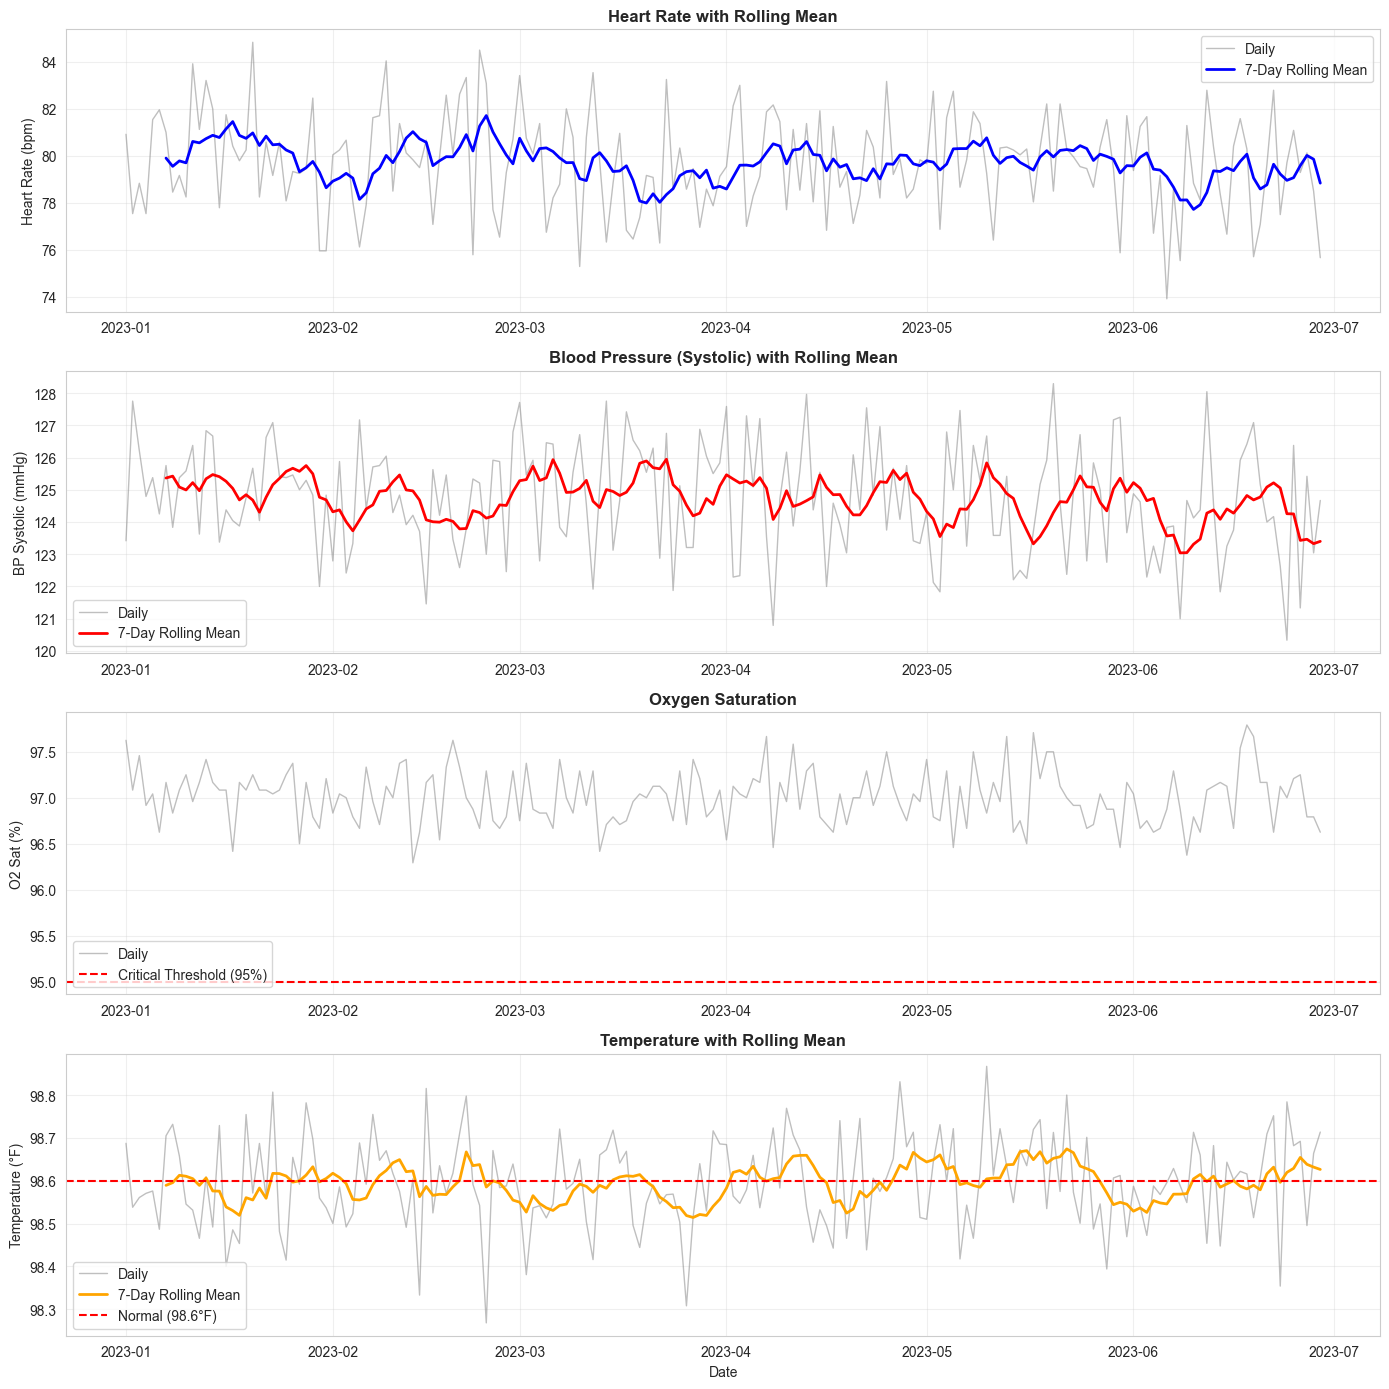

In [14]:
# Create comprehensive multi-variable visualization
fig, axes = plt.subplots(4, 1, figsize=(14, 14))

# Heart rate
axes[0].plot(daily_summary.index, daily_summary['heart_rate'], 
             alpha=0.5, linewidth=1, label='Daily', color='gray')
axes[0].plot(daily_summary.index, daily_summary['hr_rolling_mean'], 
             linewidth=2, label='7-Day Rolling Mean', color='blue')
axes[0].set_title('Heart Rate with Rolling Mean', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Heart Rate (bpm)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Blood pressure
axes[1].plot(daily_summary.index, daily_summary['blood_pressure_systolic'], 
             alpha=0.5, linewidth=1, label='Daily', color='gray')
axes[1].plot(daily_summary.index, daily_summary['bp_rolling_mean'], 
             linewidth=2, label='7-Day Rolling Mean', color='red')
axes[1].set_title('Blood Pressure (Systolic) with Rolling Mean', fontsize=12, fontweight='bold')
axes[1].set_ylabel('BP Systolic (mmHg)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Oxygen saturation
axes[2].plot(daily_summary.index, daily_summary['oxygen_saturation'], 
             alpha=0.5, linewidth=1, label='Daily', color='gray')
axes[2].axhline(y=95, color='red', linestyle='--', label='Critical Threshold (95%)')
axes[2].set_title('Oxygen Saturation', fontsize=12, fontweight='bold')
axes[2].set_ylabel('O2 Sat (%)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# Temperature
axes[3].plot(daily_summary.index, daily_summary['temperature'], 
             alpha=0.5, linewidth=1, label='Daily', color='gray')
axes[3].plot(daily_summary.index, daily_summary['temp_rolling_mean'], 
             linewidth=2, label='7-Day Rolling Mean', color='orange')
axes[3].axhline(y=98.6, color='red', linestyle='--', label='Normal (98.6°F)')
axes[3].set_title('Temperature with Rolling Mean', fontsize=12, fontweight='bold')
axes[3].set_xlabel('Date')
axes[3].set_ylabel('Temperature (°F)')
axes[3].legend()
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

This multi-variable visualization allows you to compare trends across different vital signs simultaneously. Notice how rolling means help identify underlying trends despite daily fluctuations, and how reference lines (like the critical oxygen saturation threshold) provide clinical context.
